In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
p = 0.01
data = pd.read_csv('data/2017_Green_Taxi_Trip_Data.csv', parse_dates=['lpep_pickup_datetime','lpep_dropoff_datetime'], infer_datetime_format=True, skiprows=lambda i: i>0 and random.random() > p)

In [3]:
data.sample(2)
#data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
25814,2,2017-03-13 15:02:55,2017-03-13 15:11:29,N,1,196,95,1,1.20,6.5,0.0,0.5,0.0,0.0,NaN,0.3,7.3,2,1
42453,2,2017-04-28 22:13:23,2017-04-28 22:21:28,N,1,41,41,1,1.07,7.0,0.5,0.5,0.0,0.0,NaN,0.3,8.3,2,1


In [53]:
data.payment_type.min()

1

In [26]:
cost_pay = pd.DataFrame(columns=['credit', 'cash', 'no_charge', 'dispute', 'unknown', 'voided']);
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_cr = d_dis[d_dis['payment_type']==1];
    d_ca = d_dis[d_dis['payment_type']==2];
    d_nc = d_dis[d_dis['payment_type']==3];
    d_dp = d_dis[d_dis['payment_type']==4];
    d_uk = d_dis[d_dis['payment_type']==5];
    d_vd = d_dis[d_dis['payment_type']==6];
    av_cr = 0
    av_ca = 0
    av_nc = 0
    av_dp = 0
    av_uk = 0
    av_vd = 0
    if (d_cr.shape[0] > 0):
        av_cr =  d_cr['fare_amount'].sum()/d_cr['trip_distance'].sum()
    if (d_ca.shape[0] > 0):
        av_ca =  d_ca['fare_amount'].sum()/d_ca['trip_distance'].sum()
    if (d_nc.shape[0] > 0):
        av_nc =  d_nc['fare_amount'].sum()/d_nc['trip_distance'].sum()
    if (d_dp.shape[0] > 0):
        av_dp =  d_dp['fare_amount'].sum()/d_dp['trip_distance'].sum()
    if (d_uk.shape[0] > 0):
        av_uk =  d_uk['fare_amount'].sum()/d_uk['trip_distance'].sum()
    if (d_vd.shape[0] > 0):
        av_vd =  d_vd['fare_amount'].sum()/d_vd['trip_distance'].sum()
    #print(av_cr)
    #print(av_ca)
    #print(av_uk)
    df_add = pd.DataFrame({'credit': av_cr, 'cash': av_ca, 'no_charge': av_nc, 'dispute': av_dp, 'unknown': av_uk, 'voided': av_vd}, index=[i])
    #print(df_add)
    cost_pay = cost_pay.append(df_add)
cost_pay

,cash,credit,dispute,no_charge,unknown,voided
0,5.392335,5.267377,2.758188,1.712823,8.000000,0
4,3.680395,3.771263,3.497442,3.194444,3.471074,0
8,3.255758,3.333930,3.463203,2.527301,0.000000,0
12,3.093967,3.168519,4.041096,3.431373,0.000000,0
16,3.002055,2.986307,3.000000,2.833021,0.000000,0
20,2.921174,3.054664,0.000000,3.227273,0.000000,0


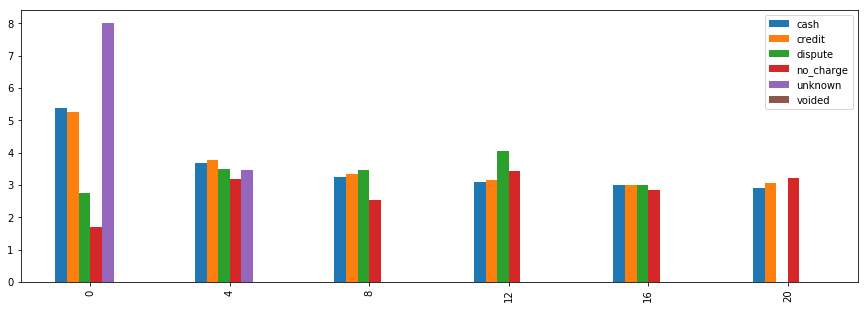

In [27]:
cost_pay.plot.bar(figsize=(15, 5))

#x= np.arange(5)
#y1=np.arange(5)
#y2 = np.ones(5)

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.plot(x,y1)
#ax.bar(x,y2)
#plt.show()
#plt_wpl = cost.plot(y='WordPerLine', kind='bar', figsize=(15, 10))
#plt_wpl.set_xlabel("Player")
#plt_wpl.set_ylabel("Words per Line")

In [24]:
cost_trip = pd.DataFrame(columns=['hail', 'dispatch']);
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_hl = d_dis[d_dis['trip_type']==1];
    d_dp = d_dis[d_dis['trip_type']==2];
    av_hl = 0
    av_dp = 0
    if (d_hl.shape[0] > 0):
        av_hl =  d_hl['total_amount'].sum()/d_hl['trip_distance'].sum()
    if (d_dp.shape[0] > 0):
        av_dp =  d_dp['total_amount'].sum()/d_dp['trip_distance'].sum()
    #print(av_cr)
    #print(av_ca)
    #print(av_uk)
    df_add = pd.DataFrame({'hail': av_hl, 'dispatch': av_dp}, index=[i])
    #print(df_add)
    cost_trip = cost_trip.append(df_add)
cost_trip

,dispatch,hail
0,14.446704,6.469440
4,3.516697,4.391897
8,3.483039,3.866830
12,3.266735,3.634475
16,3.255228,3.584008
20,2.858545,3.539154


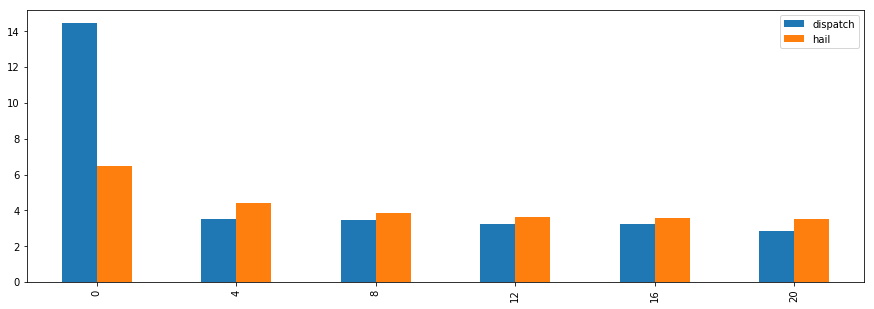

In [25]:
cost_trip.plot.bar(figsize=(15, 5))

In [46]:
#data[data['passenger_count']==0]

In [33]:
d_check = data[(data['trip_distance'] >= 0) & (data['trip_distance'] < (4))]
d_check = d_check[d_check['trip_type'] ==2]
d_check

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
16,2,01/01/2017 12:00:01 AM,01/01/2017 12:00:05 AM,N,5,36,36,1,0.00,3.0,0.0,0.0,0.0,0.0,NaN,0.0,3.0,1,2
38,2,01/01/2017 12:01:57 AM,01/01/2017 12:02:01 AM,N,5,75,75,1,0.00,5.0,0.0,0.0,2.0,0.0,NaN,0.0,7.0,1,2
496,2,01/01/2017 12:28:36 AM,01/01/2017 12:28:36 AM,N,5,127,127,1,0.00,16.0,0.0,0.0,0.0,0.0,NaN,0.3,16.3,1,2
545,2,01/01/2017 12:24:36 AM,01/01/2017 12:24:39 AM,N,5,264,193,1,0.26,45.0,0.0,0.0,0.0,0.0,NaN,0.0,45.0,1,2
652,2,01/01/2017 12:29:43 AM,01/01/2017 12:30:58 AM,N,5,254,254,1,0.17,14.0,0.0,0.0,0.0,0.0,NaN,0.0,14.0,1,2
789,2,01/01/2017 12:23:51 AM,01/01/2017 12:23:53 AM,N,5,264,196,1,0.00,25.0,0.0,0.0,5.0,0.0,NaN,0.0,30.0,1,2


In [5]:
data['hour'] = data.lpep_pickup_datetime.apply(lambda t:t.hour)
data['date_in_week'] = data.lpep_pickup_datetime.apply(lambda t:t.weekday())
data['month'] = data.lpep_pickup_datetime.apply(lambda t:t.month)
data.sample(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,hour,date_in_week,month
86652,2,2017-09-19 17:39:41,2017-09-19 17:51:42,N,1,65,97,1,1.57,9.5,...,1.0,0.0,NaN,0.3,12.3,1,1,17,1,9
48786,2,2017-05-16 19:45:54,2017-05-16 19:53:35,N,1,95,135,1,1.58,7.5,...,0.0,0.0,NaN,0.3,8.8,1,1,19,1,5


In [9]:
cost_hr = pd.DataFrame(columns=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
ct_hr = pd.DataFrame(columns=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_00 = d_dis[d_dis['hour']==0];
    d_01 = d_dis[d_dis['hour']==1];
    d_02 = d_dis[d_dis['hour']==2];
    d_03 = d_dis[d_dis['hour']==3];
    d_04 = d_dis[d_dis['hour']==4];
    d_05 = d_dis[d_dis['hour']==5];
    d_06 = d_dis[d_dis['hour']==6];
    d_07 = d_dis[d_dis['hour']==7];
    d_08 = d_dis[d_dis['hour']==8];
    d_09 = d_dis[d_dis['hour']==9];
    d_10 = d_dis[d_dis['hour']==10];
    d_11 = d_dis[d_dis['hour']==11];
    d_12 = d_dis[d_dis['hour']==12];
    d_13 = d_dis[d_dis['hour']==13];
    d_14 = d_dis[d_dis['hour']==14];
    d_15 = d_dis[d_dis['hour']==15];
    d_16 = d_dis[d_dis['hour']==16];
    d_17 = d_dis[d_dis['hour']==17];
    d_18 = d_dis[d_dis['hour']==18];
    d_19 = d_dis[d_dis['hour']==19];
    d_20 = d_dis[d_dis['hour']==20];
    d_21 = d_dis[d_dis['hour']==21];
    d_22 = d_dis[d_dis['hour']==22];
    d_23 = d_dis[d_dis['hour']==23];
    av_00 = 0
    av_01 = 0
    av_02 = 0
    av_03 = 0
    av_04 = 0
    av_05 = 0
    av_06 = 0
    av_07 = 0
    av_08 = 0
    av_09 = 0
    av_10 = 0
    av_11 = 0
    av_12 = 0
    av_13 = 0
    av_14 = 0
    av_15 = 0
    av_16 = 0
    av_17 = 0
    av_18 = 0
    av_19 = 0
    av_20 = 0
    av_21 = 0
    av_22 = 0
    av_23 = 0
    if (d_00.shape[0] > 0):
        av_00 =  d_00['fare_amount'].sum()/d_00['trip_distance'].sum()
    if (d_01.shape[0] > 0):
        av_01 =  d_01['fare_amount'].sum()/d_01['trip_distance'].sum()
    if (d_02.shape[0] > 0):
        av_02 =  d_02['fare_amount'].sum()/d_02['trip_distance'].sum()
    if (d_03.shape[0] > 0):
        av_03 =  d_03['fare_amount'].sum()/d_03['trip_distance'].sum()
    if (d_04.shape[0] > 0):
        av_04 =  d_04['fare_amount'].sum()/d_04['trip_distance'].sum()
    if (d_05.shape[0] > 0):
        av_05 =  d_05['fare_amount'].sum()/d_05['trip_distance'].sum()
    if (d_06.shape[0] > 0):
        av_06 =  d_06['fare_amount'].sum()/d_06['trip_distance'].sum()
    if (d_07.shape[0] > 0):
        av_07 =  d_07['fare_amount'].sum()/d_07['trip_distance'].sum()
    if (d_08.shape[0] > 0):
        av_08 =  d_08['fare_amount'].sum()/d_08['trip_distance'].sum()
    if (d_09.shape[0] > 0):
        av_09 =  d_09['fare_amount'].sum()/d_09['trip_distance'].sum()
    if (d_10.shape[0] > 0):
        av_10 =  d_10['fare_amount'].sum()/d_10['trip_distance'].sum()
    if (d_11.shape[0] > 0):
        av_11 =  d_11['fare_amount'].sum()/d_11['trip_distance'].sum()
    if (d_12.shape[0] > 0):
        av_12 =  d_12['fare_amount'].sum()/d_12['trip_distance'].sum()
    if (d_13.shape[0] > 0):
        av_13 =  d_13['fare_amount'].sum()/d_13['trip_distance'].sum()
    if (d_14.shape[0] > 0):
        av_14 =  d_14['fare_amount'].sum()/d_14['trip_distance'].sum()
    if (d_15.shape[0] > 0):
        av_15 =  d_15['fare_amount'].sum()/d_15['trip_distance'].sum()
    if (d_16.shape[0] > 0):
        av_16 =  d_16['fare_amount'].sum()/d_16['trip_distance'].sum()
    if (d_17.shape[0] > 0):
        av_17 =  d_17['fare_amount'].sum()/d_17['trip_distance'].sum()
    if (d_18.shape[0] > 0):
        av_18 =  d_18['fare_amount'].sum()/d_18['trip_distance'].sum()
    if (d_19.shape[0] > 0):
        av_19 =  d_19['fare_amount'].sum()/d_19['trip_distance'].sum()
    if (d_20.shape[0] > 0):
        av_20 =  d_20['fare_amount'].sum()/d_20['trip_distance'].sum()
    if (d_21.shape[0] > 0):
        av_21 =  d_21['fare_amount'].sum()/d_21['trip_distance'].sum()
    if (d_22.shape[0] > 0):
        av_22 =  d_22['fare_amount'].sum()/d_22['trip_distance'].sum()
    if (d_23.shape[0] > 0):
        av_23 =  d_23['fare_amount'].sum()/d_23['trip_distance'].sum()
    #print(av_cr)
    #print(av_ca)
    #print(av_uk)
    df_add = pd.DataFrame({'00':av_00,'01':av_01,'02':av_02,'03':av_03,'04':av_04,'05':av_05,'06':av_06,'07':av_07,'08':av_08,'09':av_09,'10':av_10,'11':av_11,'12':av_12,'13':av_13,'14':av_14,'15':av_15,'16':av_16,'17':av_17,'18':av_18,'19':av_19,'20':av_20,'21':av_21,'22':av_22,'23':av_23}, index=[i])
    df_add_ct = pd.DataFrame({'00':d_00.shape[0],'01':d_01.shape[0],'02':d_02.shape[0],'03':d_03.shape[0],'04':d_04.shape[0],'05':d_05.shape[0],'06':d_06.shape[0],'07':d_07.shape[0],'08':d_08.shape[0],'09':d_09.shape[0],'10':d_10.shape[0],'11':d_11.shape[0],'12':d_12.shape[0],'13':d_13.shape[0],'14':d_14.shape[0],'15':d_15.shape[0],'16':d_16.shape[0],'17':d_17.shape[0],'18':d_18.shape[0],'19':d_19.shape[0],'20':d_20.shape[0],'21':d_21.shape[0],'22':d_22.shape[0],'23':d_23.shape[0]}, index=[i])
    #print(df_add)
    cost_hr = cost_hr.append(df_add)
    ct_hr = ct_hr.append(df_add_ct)
cost_hr.sample(2)

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
16,2.933807,2.891498,2.772986,2.943163,2.803774,2.793303,2.906996,3.039888,3.001348,2.927336,...,3.027888,3.213547,3.071490,3.021586,2.919798,2.884266,2.917817,2.984443,2.990050,2.975133
12,2.944151,3.085429,2.952540,2.885564,2.952211,2.980302,3.061042,3.309220,3.192170,2.999167,...,3.367009,3.295377,3.404306,3.466016,3.142392,3.060940,3.015503,2.994565,3.067545,3.113804


In [31]:
cost_hr = cost_hr.transpose()
cost_hr

,0,4,8,12,16,20
00,4.858991,3.558200,3.154228,2.944151,2.933807,3.502185
01,4.826275,3.441552,3.132800,3.085429,2.891498,2.745158
02,4.879611,3.460542,3.032668,2.952540,2.772986,2.702052
03,5.001034,3.431387,3.201794,2.885564,2.943163,3.377218
04,4.798909,3.377802,3.052646,2.952211,2.803774,2.675580
05,4.775568,3.318751,3.052110,2.980302,2.793303,2.778825
06,4.765121,3.439009,3.137134,3.061042,2.906996,2.863241
07,5.280190,3.711307,3.402047,3.309220,3.039888,2.648544
08,5.498580,3.865560,3.447402,3.192170,3.001348,2.642619
09,5.424445,3.852956,3.366709,2.999167,2.927336,2.918177


In [13]:
ct_hr = ct_hr.transpose()
ct_hr.sample(2)

,0,4,8,12,16,20
20,5865,889,182,46,20,12
03,1467,360,115,23,11,3


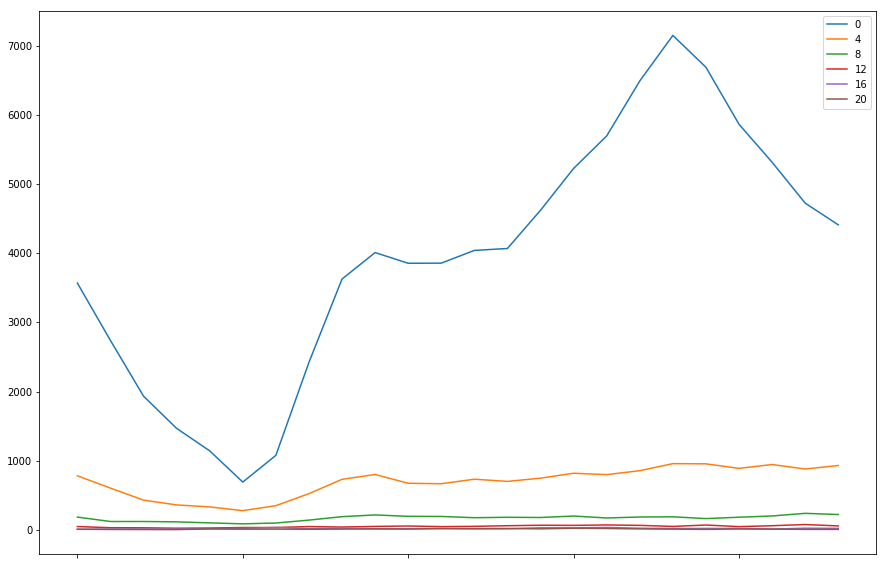

In [17]:
ct_hr.plot.line(figsize=(15, 10))

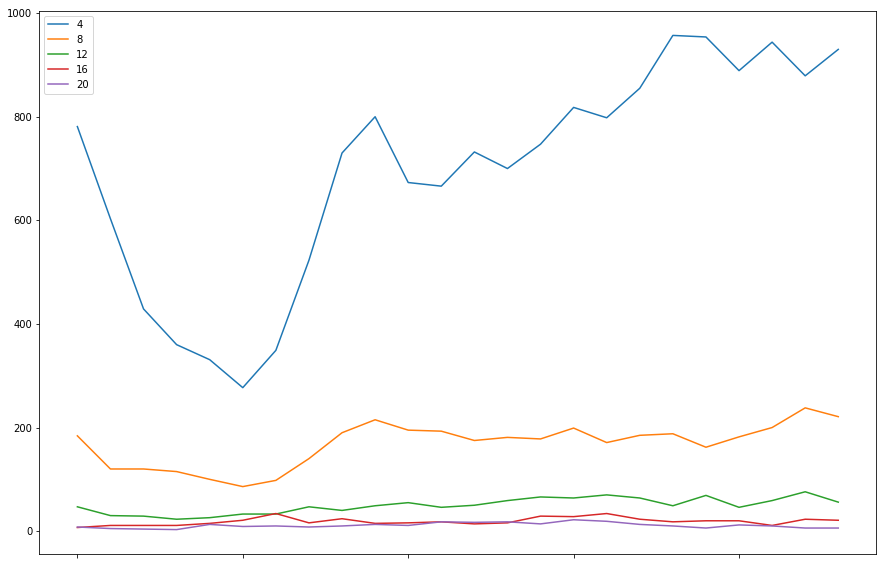

In [24]:
#ct_hr
#del ct_hr[0]
ct_hr.plot.line(figsize=(15, 10))

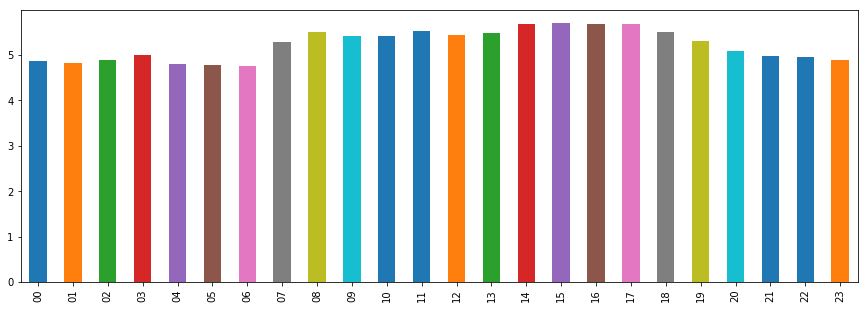

In [14]:
cost_hr.loc[0].plot.bar(figsize=(15, 5))

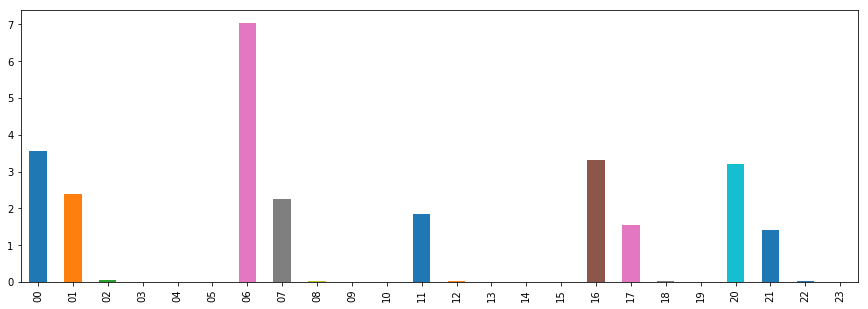

In [42]:
cost_hr.loc[4].plot.bar(figsize=(15, 5))

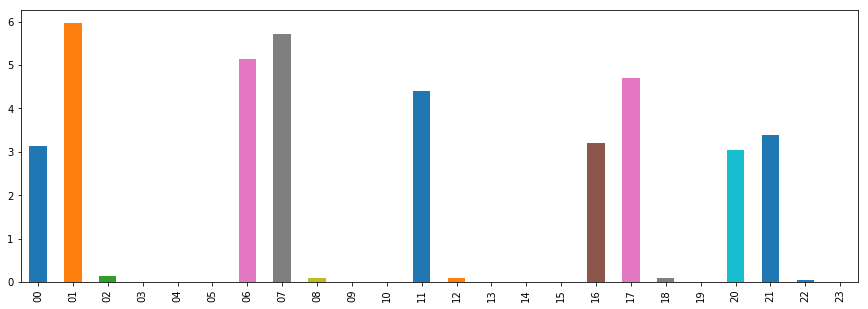

In [43]:
cost_hr.loc[8].plot.bar(figsize=(15, 5))

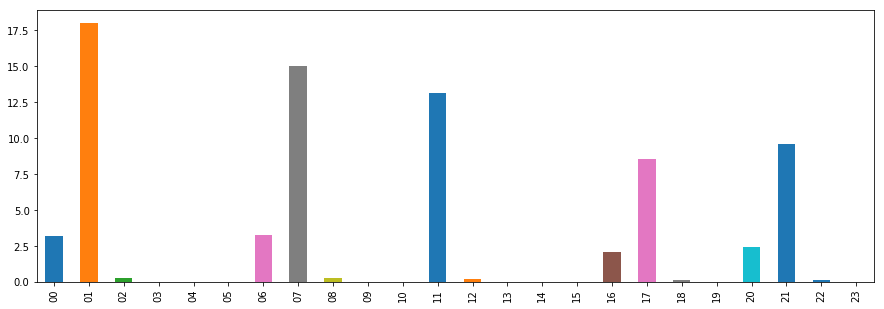

In [44]:
cost_hr.loc[12].plot.bar(figsize=(15, 5))

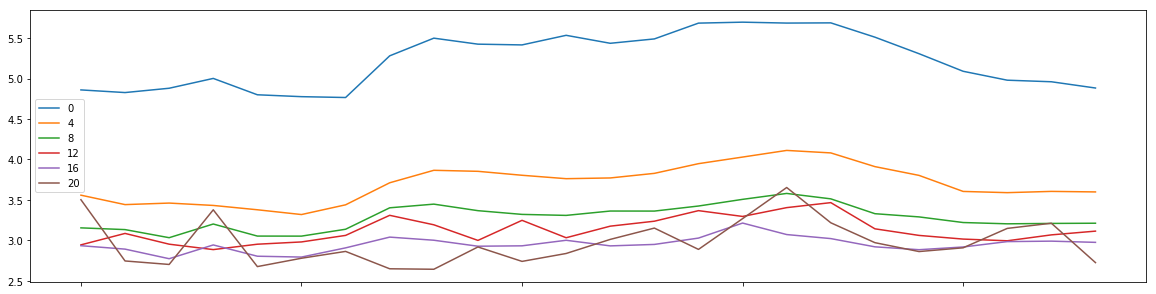

In [32]:
cost_hr.plot.line(figsize=(20, 5))

In [64]:
cost_diw = pd.DataFrame(columns=['0','1','2','3','4','5','6'])
for i in range (0, 24, 4):
    if (i == 20):
        d_dis = data[(data['trip_distance'] >= i)]
    else:
        d_dis = data[(data['trip_distance'] >= i) & (data['trip_distance'] < (i+4))];
    d_0 = d_dis[d_dis['date_in_week']==0];
    d_1 = d_dis[d_dis['date_in_week']==1];
    d_2 = d_dis[d_dis['date_in_week']==2];
    d_3 = d_dis[d_dis['date_in_week']==3];
    d_4 = d_dis[d_dis['date_in_week']==4];
    d_5 = d_dis[d_dis['date_in_week']==5];
    d_6 = d_dis[d_dis['date_in_week']==6];
    av_0 = 0
    av_1 = 0
    av_2 = 0
    av_3 = 0
    av_4 = 0
    av_5 = 0
    av_6 = 0
    if (d_0.shape[0] > 0):
        av_0 =  d_0['fare_amount'].sum()/d_0['trip_distance'].sum()
    if (d_1.shape[0] > 0):
        av_1 =  d_1['fare_amount'].sum()/d_1['trip_distance'].sum()
    if (d_2.shape[0] > 0):
        av_2 =  d_2['fare_amount'].sum()/d_2['trip_distance'].sum()
    if (d_3.shape[0] > 0):
        av_3 =  d_3['fare_amount'].sum()/d_3['trip_distance'].sum()
    if (d_4.shape[0] > 0):
        av_4 =  d_4['fare_amount'].sum()/d_4['trip_distance'].sum()
    if (d_5.shape[0] > 0):
        av_5 =  d_5['fare_amount'].sum()/d_5['trip_distance'].sum()
    if (d_6.shape[0] > 0):
        av_6 =  d_6['fare_amount'].sum()/d_6['trip_distance'].sum()
    df_add = pd.DataFrame({'0':av_0,'1':av_1,'2':av_2,'3':av_3,'4':av_4,'5':av_5,'6':av_6}, index=[i])
    #print(df_add)
    cost_diw = cost_diw.append(df_add)
#cost_diw = cost_diw.transpose()
cost_diw

,0,1,2,3,4,5,6
0,5.299652,5.349704,5.430777,5.460141,5.456637,5.200867,5.037463
4,3.705681,3.761875,3.784970,3.856762,3.821510,3.682264,3.584018
8,3.245092,3.304043,3.350334,3.401149,3.393398,3.279456,3.194101
12,3.188037,3.132937,3.212051,3.169616,3.212973,3.058755,3.088757
16,2.974482,2.952497,2.946028,2.991891,3.023491,3.110382,2.923191
20,3.119631,3.012013,3.160545,2.827807,2.978640,2.927266,3.026124


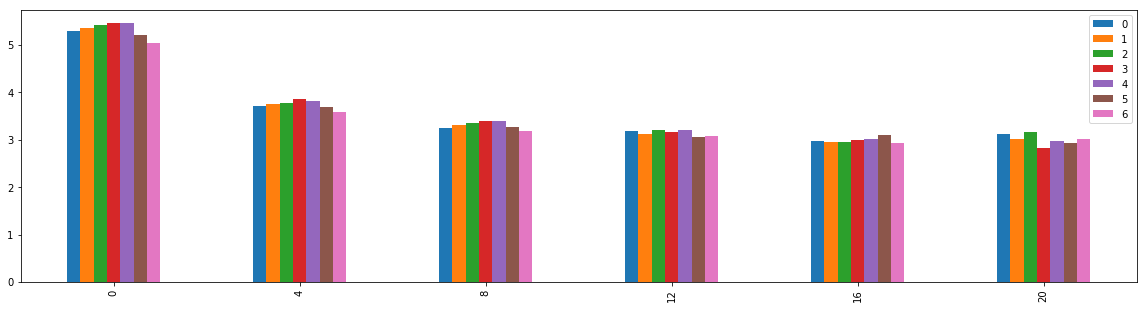

In [65]:
cost_diw.plot.bar(figsize=(20, 5))

In [29]:
data[data['RatecodeID'] == 6]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,hour,date_in_week,month
39546,1,2017-04-20 23:16:47,2017-04-20 23:17:25,N,6,119,247,1,0.2,2.5,...,0.0,0.0,NaN,0.3,3.3,4,1,23,3,4
